In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import romb
from scipy.stats import chi2, norm, rv_continuous, kstest, ks_2samp
from scipy.optimize import minimize
np.random.seed(276814)

In [2]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.rc('legend',fontsize=15)
plt.rc('font',size=15)

In [7]:
def model(x,pars):
    a = pars[0]
    m0 = pars[1]
    theta = np.pi/2. - 0.3
    gamma = 1
    xint = np.linspace(5, 18, 2**13+1)
    val_model = lambda x: np.abs(1+a*np.exp(1j*theta)/((x**2-(m0)**2)+1j*m0*gamma))**2
    if (type(a) is not np.ndarray) and type(m0) is not np.ndarray:
        integral = romb(val_model(xint), 0.1)
        return val_model(x)/integral
    else:
        a = a.reshape(-1,1)
        m0 = m0.reshape(-1,1)
        integral = romb(val_model(xint), 1, axis=1).reshape(-1,1)
        return val_model(x)/integral
    
def generate_data(a, m0):
    x = np.random.uniform(5, 18, 1000000)
    y = model(x,[a, m0])
    return x[np.random.uniform(0, np.max(y), 1000000) < y][:ndata] #accept-reject


def nll(data, model, pars):
    log = np.log(model(data, pars))
    if len(log.shape) == 1: return -np.sum(np.log(model(data,pars)))
    else: return -np.sum(np.log(model(data,pars)),axis=1)

### Punto 1 i)

In [8]:
data = np.array([])
f = open("Data.txt", "r")
for line in f.readlines():
    data = np.append(data, float(line))
f.close()

In [9]:
len(data)

300

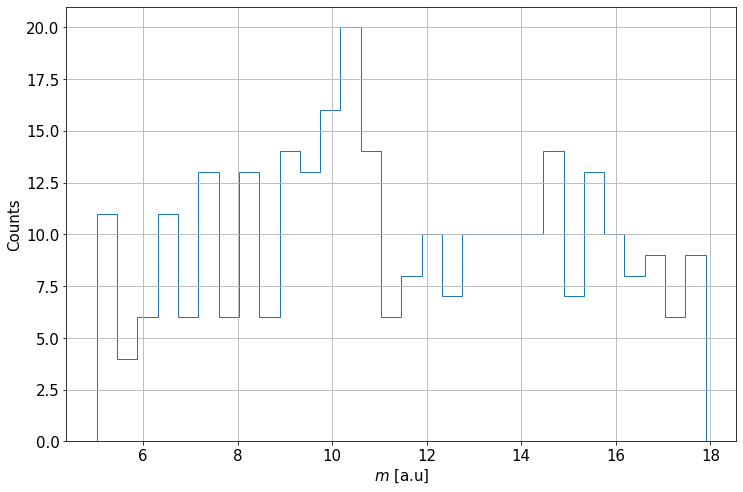

In [10]:
dataf, bins,_ = plt.hist(data,bins=30,histtype='step')
plt.xlabel(r'$m$ [a.u]')
plt.ylabel('Counts')
plt.grid(True)
plt.savefig("Data.png", bbox_inches='tight')

In [11]:
m0bar = np.arange(5., 18., 0.1)
L_Hnull = nll(data, model, [0,0])
t_null = np.array([])

for i in range (len(m0bar)):
    res = minimize(lambda pars: nll(data, model, pars), x0 = [0, m0bar[i]], constraints = ({'type': 'eq', 'fun': lambda pars: pars[1]-m0bar[i]}))
    t_null = np.append(t_null, -2*(res.fun - L_Hnull))

In [12]:
L_Hnull

2012.4984762855727

In [13]:
#Assumo il limite asintotico: t_null distribuito come un chi2 con un gdl
pvalue = np.array([])
for i in range (len(m0bar)):
    pvalue = np.append(pvalue, 1-chi2(1).cdf(t_null[i]))

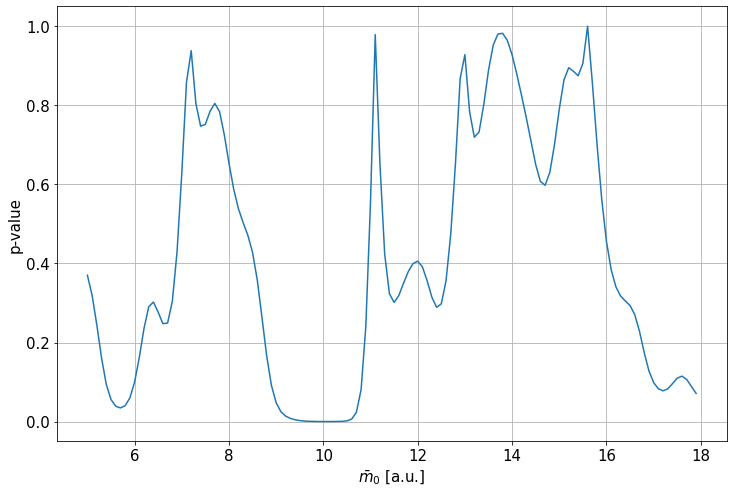

In [14]:
plt.plot(m0bar, pvalue)
plt.xlabel(r'$\bar{m}_{0}$ [a.u.]')
plt.ylabel('p-value')
plt.grid(True)
plt.savefig("Es61i.png", bbox_inches='tight')

### Punto 1 ii)

In [15]:
devstd = np.array([])

for i in range (len(m0bar)):
    devstd = np.append(devstd, (norm.ppf(1-pvalue[i]/2)))

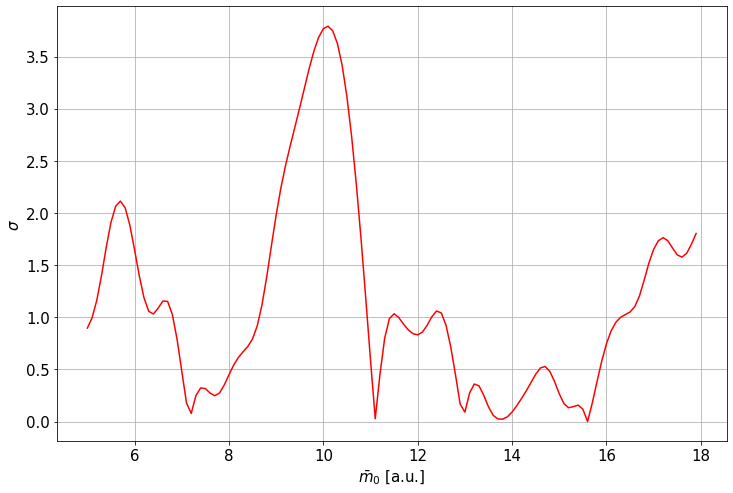

In [16]:
plt.plot(m0bar, devstd, color='r')
plt.xlabel(r'$\bar{m}_{0}$ [a.u.]')
plt.ylabel(r'$\sigma$')
plt.grid(True)
plt.savefig("Es61ii.png", bbox_inches='tight')

### Punto 2

In [17]:
data_fit = minimize(lambda pars: nll(data, model, pars), x0=[5, 10])
t_obs = -2*(data_fit.fun - L_Hnull)
print(data_fit)
print(str(t_obs))

      fun: 2005.3095448900713
 hess_inv: array([[ 3.66799371, -0.32144833],
       [-0.32144833,  0.0612529 ]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 6
     njev: 10
   status: 0
  success: True
        x: array([ 5.09471532, 10.08708651])
14.377862791002826


In [ ]:
ndata = 300
N = 10000
t = np.array([])

for i in range (N):
    toy_data_bkg = generate_data(a=0, m0=0)
    L_bkg = nll(toy_data_bkg, model, [0,0])
    res = minimize(lambda pars: nll(toy_data_bkg, model, pars), x0 = [0,0])
    t = np.append(t, 2*(L_bkg - res.fun))
    
    #Scrivo su file quanto ottengo -> cambia nome al file nel caso i e ii
    file = open("t_statistics.txt", "a")
    file.write(str(t[i]) + "\n")
    file.close()
    
pvalue = len(t[t >= t_obs]) / len(t)
print('p-value = %f'%pvalue)

In [18]:
t_tot = np.array([])
f = open("t_statistics.txt", "r")
for line in f.readlines():
    t_tot = np.append(t_tot, float(line))
f.close()

pvalue = len(t_tot[t_tot >= t_obs]) / len(t_tot)
print('p-value = %f'%pvalue)

p-value = 0.000700


significance = 3.389579


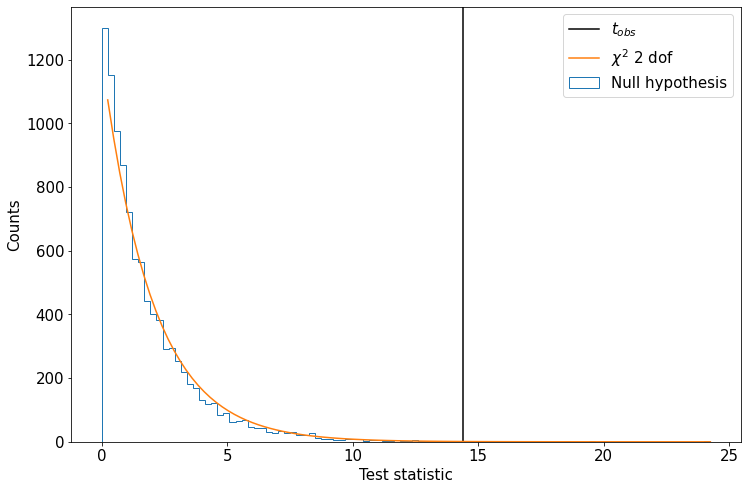

In [19]:
N = len(t_tot)
dataf, bins,_ = plt.hist(t_tot,bins=100,histtype='step',label='Null hypothesis')
x = np.linspace(bins[1:].min(),bins.max(),101)
plt.xlabel('Test statistic')
plt.ylabel('Counts')
plt.axvline(t_obs,color='black',label='$t_{obs}$')
plt.plot(x,chi2(2).pdf(x)*N*(bins.max()-bins.min())/100,label='$\chi^2$ 2 dof')
plt.legend(loc='best')
print('significance = %f'%((norm.ppf(1-pvalue/2))))
plt.savefig("Es62ii.png", bbox_inches='tight')